# Computing temperature-dependent intrinsic parameters (Python interface to UppASD)

In this notebook we show how we can get temperature dependent Ms, A, and K by running spindynamics simulations for a range of temperatures and then fitting the Kuzmin equation to the resulting M(T). From the fit we can get A(T) and K(T).

After that we discuss different possibilities to extract Tc from the spindynamics simulations.

:::{warning}
In order to keep the runtime for this notebook short, we will use small values for `ncell`, `ip_mcnstep` and `mcnstep`. For production calculations you should choose larger values.
:::

In [1]:
import mammos_spindynamics
import mammos_dft
import mammos_analysis
import mammos_units as u
import mammos_entity as me

import matplotlib.pyplot as plt
import numpy as np

## Creating the simulation object

First, we need to create a simulation object. We assume that we already have three files `posfile`, `momfile` and `jfile` in our current working directory and that they are in the form required for UppASD. We will not create `inpsd.dat` manually but instead rely on the simulation object. We can pass all required options for the input file as arguments when creating the simulation object or when calling one of its functions. Here, we will pass most arguments at creation time and only temperature values at runtime.

We take TODO as an example for this notebook.

In [2]:
material = "Fe2.33Ta0.67Y"

In [3]:
spindynamics_input = mammos_dft.db.get_uppasd_properties(material)
spindynamics_input

UppasdProperties(Fe2.33Ta0.67Y)

In [4]:
simulation = mammos_spindynamics.uppasd.Simulation(
    cell=spindynamics_input.cell,
    alat=1e-10,
    ncell=(12, 12, 12),
    posfile=spindynamics_input.posfile,
    posfiletype=spindynamics_input.posfiletype,
    momfile=spindynamics_input.momfile,
    exchange=spindynamics_input.exchange,
    maptype=spindynamics_input.maptype,
    initmag=3,
    ip_mcnstep=100,
    mcnstep=200,
)
simulation

Simulation(
    inpsd_dat=None,
    ncell=(12, 12, 12),
    ip_mcnstep=100,
    mcnstep=200,
    cell=Cell([[5.227483, 0.0, 0.0], [-2.613741499999999, 4.527133075851289, 0.0], [0.0, 0.0, 25.022642]]),
    alat=1e-10,
    posfile=PosixPath('/home/mlang/repos/mammos/mammos-devtools/packages/mammos-dft/src/mammos_dft/data/0007/posfile'),
    posfiletype='D',
    momfile=PosixPath('/home/mlang/repos/mammos/mammos-devtools/packages/mammos-dft/src/mammos_dft/data/0007/momfile'),
    exchange=PosixPath('/home/mlang/repos/mammos/mammos-devtools/packages/mammos-dft/src/mammos_dft/data/0007/exchange'),
    maptype=2,
    initmag=3,
)

## Running a temperature sweep

We now want to run simulations for a series of temperatures between 50 and 900 Kelvin, in steps of 200 Kelvin. We can use the `range` function to get all temperatures. The simulation object provides a method to automatically run all simulations sequentially.

TODO We can tell it to use the restart file of the previous calculation as starting point for the next simulation. For the first simulation it will use `Initmag=1`, which we have set above.

In [5]:
coarse_sweep = simulation.temperature_sweep(T=range(50, 900, 200), out=material) # TODO explain out

Running simulations for 5 different temperatures:
    [50, 250, 450, 650, 850]
T=50: Running UppASD in Fe2.33Ta0.67Y/0-temperature_sweep/0-run ... simulation finished, took 0:00:06
T=250: Running UppASD in Fe2.33Ta0.67Y/0-temperature_sweep/1-run ... simulation finished, took 0:00:07
T=450: Running UppASD in Fe2.33Ta0.67Y/0-temperature_sweep/2-run ... simulation finished, took 0:00:08
T=650: Running UppASD in Fe2.33Ta0.67Y/0-temperature_sweep/3-run ... simulation finished, took 0:00:08
T=850: Running UppASD in Fe2.33Ta0.67Y/0-temperature_sweep/4-run ... simulation finished, took 0:00:07


Text(0, 0.5, 'Spontaneous Magnetization (A / m)')

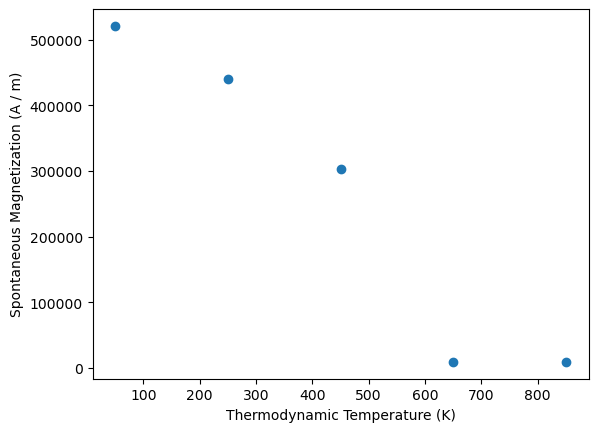

In [6]:
plt.plot(coarse_sweep.T.value, coarse_sweep.Ms.value, "o")
plt.xlabel(coarse_sweep.T.axis_label)
plt.ylabel(coarse_sweep.Ms.axis_label)

From the few simulations we can see that Tc is somewhere between 500 K and 600 K.

## Refining data around Tc

We now run a second sweep with a finer spacing of 40 Kelvin, to better resolve the area around Tc. We can restart the simulation from the result at 450 K, for which we can access the restart file via the `coarse_sweep` object.

In [7]:
simulation.temperature_sweep(
    T=range(490, 650, 40),
    out=material,
    initmag=4,
    restartfile=coarse_sweep.get(T=450).restartfile,
);

Running simulations for 4 different temperatures:
    [490, 530, 570, 610]
T=490: Running UppASD in Fe2.33Ta0.67Y/1-temperature_sweep/0-run ... simulation finished, took 0:00:08
T=530: Running UppASD in Fe2.33Ta0.67Y/1-temperature_sweep/1-run ... simulation finished, took 0:00:07
T=570: Running UppASD in Fe2.33Ta0.67Y/1-temperature_sweep/2-run ... simulation finished, took 0:00:10
T=610: Running UppASD in Fe2.33Ta0.67Y/1-temperature_sweep/3-run ... simulation finished, took 0:00:09


## Analyzing simulation output

First, we create a data object, which we point to the top-level output directory `Fe2.33Ta0.67Y`. The object recursively finds all files in this directory and provides access to the simulation results from within Python.

In [10]:
data = mammos_spindynamics.uppasd.read(material)

In [128]:
data.info(include_time_elapsed=False)

,name,description,T,initmag,restartfile,comment,ncell
0,0-temperature_sweep,,"[50, 250, 450, 650, 850]",NaN,NaN,NaN,NaN
1,1-temperature_sweep,,"[490, 530, 570, 610]",4.0,Fe2.33Ta0.67Y/0-temperature_sweep/2-run/restar...,NaN,NaN
2,2-temperature_sweep,,"[50.0, 250.0, 450.0, 490.0, 530.0, 570.0, 610....",NaN,NaN,larger system size for U Binder,"[16, 16, 16]"


In [12]:
coarse_sweep.info()

,name,description,time_elapsed,T,initmag,restartfile
0,0-run,,0:00:06,50,NaN,NaN
1,1-run,,0:00:07,250,4.0,Fe2.33Ta0.67Y/0-temperature_sweep/0-run/restar...
2,2-run,,0:00:08,450,4.0,Fe2.33Ta0.67Y/0-temperature_sweep/1-run/restar...
3,3-run,,0:00:08,650,4.0,Fe2.33Ta0.67Y/0-temperature_sweep/2-run/restar...
4,4-run,,0:00:07,850,4.0,Fe2.33Ta0.67Y/0-temperature_sweep/3-run/restar...


In [13]:
fine_sweep = data.get(name='1-temperature_sweep')

In [127]:
data

MammosUppasdData('Fe2.33Ta0.67Y')

In [123]:
fine_sweep[1]

RunData('Fe2.33Ta0.67Y/1-temperature_sweep/1-run')

In [125]:
fine_sweep.get(T=530)

RunData('Fe2.33Ta0.67Y/1-temperature_sweep/1-run')

In [126]:
fine_sweep.get(name='1-run')

RunData('Fe2.33Ta0.67Y/1-temperature_sweep/1-run')

In [14]:
fine_sweep.info()

,name,description,time_elapsed,T,initmag,restartfile
0,0-run,,0:00:08,490,4,Fe2.33Ta0.67Y/0-temperature_sweep/2-run/restar...
1,1-run,,0:00:07,530,4,Fe2.33Ta0.67Y/1-temperature_sweep/0-run/restar...
2,2-run,,0:00:10,570,4,Fe2.33Ta0.67Y/1-temperature_sweep/1-run/restar...
3,3-run,,0:00:09,610,4,Fe2.33Ta0.67Y/1-temperature_sweep/2-run/restar...


In [ ]:
fine_sweep

In [15]:
T_combined = me.concat_flat(coarse_sweep.T, fine_sweep.T)
Ms_combined = me.concat_flat(coarse_sweep.Ms, fine_sweep.Ms)

Text(0, 0.5, 'Spontaneous Magnetization (A / m)')

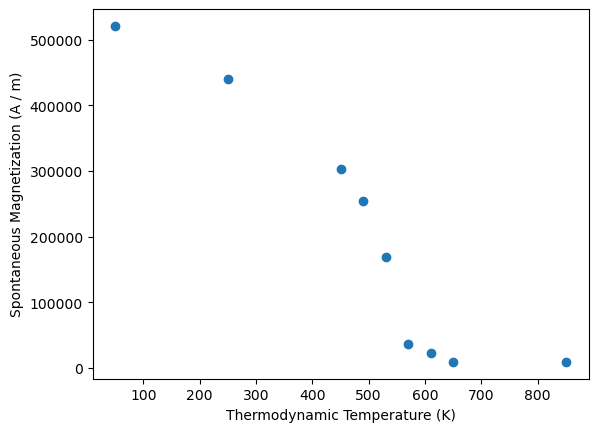

In [16]:
plt.plot(T_combined.value, Ms_combined.value, "o")
plt.xlabel(T_combined.axis_label)
plt.ylabel(Ms_combined.axis_label)

For this material pre-computed values for Ms are available in the database. We can compare the two to see how much we loos in accuracy by using only very few samples:

<Axes: xlabel='Thermodynamic Temperature (K)', ylabel='Spontaneous Magnetization (A / m)'>

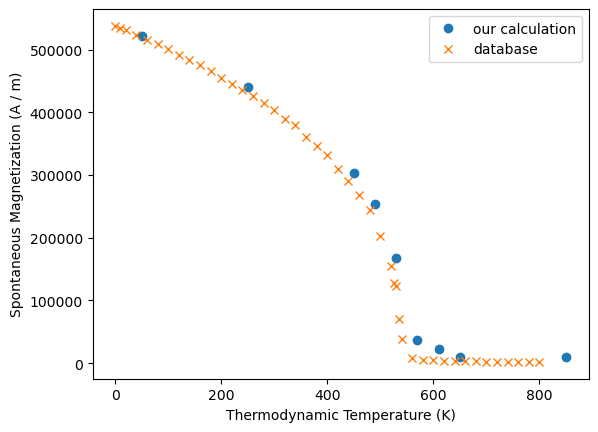

In [26]:
db_values = mammos_spindynamics.db.get_spontaneous_magnetization(chemical_formula=material)

plt.plot(T_combined.value, Ms_combined.value, "o", label="our calculation")
db_values.plot(ax=plt.gca(), label="database")

## Kuzmin fit

We can now pass the data from the temperature sweep to the Kuzmin function in `mammos_analysis`:

In [18]:
import mammos_dft
import mammos_analysis

In [85]:
kuzmin_result = mammos_analysis.kuzmin.kuzmin_properties(
    T=T_combined, Ms=Ms_combined
)

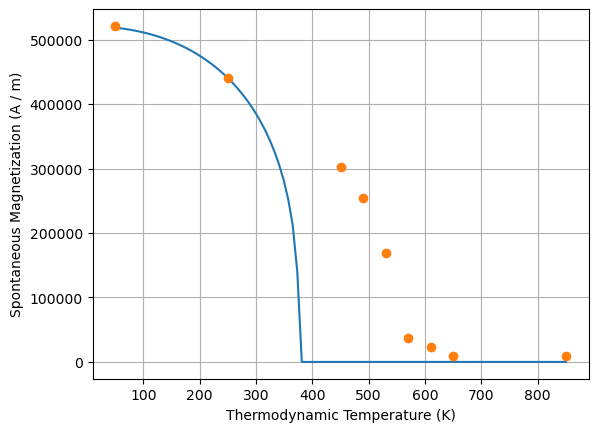

In [22]:
kuzmin_result.Ms.plot()
plt.plot(T_combined.value, Ms_combined.value, "o")

<Axes: xlabel='Thermodynamic Temperature (K)', ylabel='Spontaneous Magnetization (A / m)'>

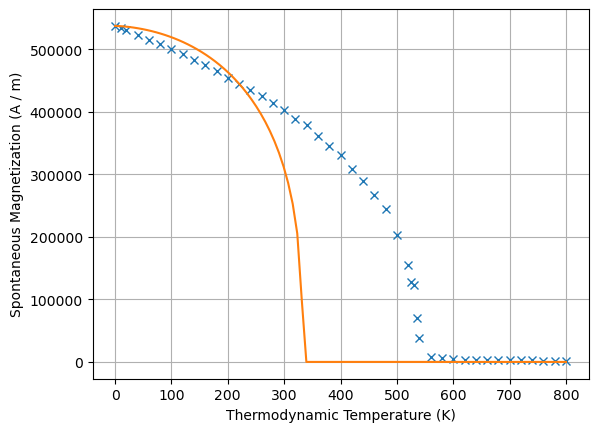

In [25]:
db_values.plot()
mammos_analysis.kuzmin_properties(T=db_values.T, Ms=db_values.Ms).Ms.plot(ax=plt.gca())

# KUZMIN IS BROKEN, LET'S TRY OURSELVES

In [87]:
import numpy as np
import scipy.optimize

In [119]:
mammos_analysis.kuzmin.kuzmin_properties?

Signature:
mammos_analysis.kuzmin.kuzmin_properties(
    Ms: 'mammos_entity.Entity',
    T: 'mammos_entity.Entity',
    Tc: 'mammos_entity.Entity | None' = None,
    Ms_0: 'mammos_entity.Entity | None' = None,
    K1_0: 'mammos_entity.Entity | None' = None,
) -> 'KuzminResult'
Docstring:
Evaluate intrinsic micromagnetic properties using Kuz’min model.

Computes Ms, A, and K1 as function of temperature by fitting the Kuz’min equation
to Ms vs T. The attributes Ms, A and K1 in the returned object can be called to get
values at arbitrary temperatures.

K1 is only available in the output data if the value of the zero-temperature
uniaxial anisotropy constant K1_0 has been passed.

If Ms_0 is None, the first value in the Ms series is taken as the zero
temperature magnetization Ms_0 only if the first entry of the T series is zero;
otherwise, a ValueError is raised.

If Tc is None, it will be treated as an optimization variable
and estimated during the fitting process via least squares.

Args:

In [ ]:
kuzmin_result = mammos_analysis.kuzmin.kuzmin_properties(
    T=T_combined, Ms=Ms_combined,
    Tc=500,
    Tc_initial_guess=None,  # default: (T.max() where Ms > 0.05 * Ms.max()) or T.max()
    Ms_0=100,
    Ms_0_initial_guess=None,  # default: Ms.max() [* 1.2?]
    s_initial_guess=0.5,
)

In [88]:
def my_kuzmin(T, Ms_0, T_c, s):
    # required to re-order arguments
    return mammos_analysis.kuzmin.kuzmin_formula(Ms_0, T_c, s, T)

In [116]:
Ms_combined.value

array([521181.45002249, 440425.50099013, 302952.81373932,   9682.8876848 ,
         9299.19206507, 254082.34583721, 168396.8918363 ,  37199.87499476,
        22903.97588455])

In [117]:
T_combined

Entity(ontology_label='ThermodynamicTemperature', value=array([ 50., 250., 450., 650., 850., 490., 530., 570., 610.]), unit='K')

In [110]:
def my_kuzmin_fit(T, Ms):
    p_opt, p_cov = scipy.optimize.curve_fit(
        my_kuzmin, T.value, Ms.value,
        p0=(Ms_combined.value[0] * 2, 250, 1)
    )
    print("Ms(T=0):", p_opt[0])
    print("Tc:", p_opt[1])
    print("s:", p_opt[2])
    return p_opt, p_cov

In [111]:
p_opt, p_cov = my_kuzmin_fit(T_combined, Ms_combined)

Ms(T=0): 711966.9824483588
Tc: 249.9998502366682
s: 8.243294775419038


/tmp/ipykernel_86161/1580605271.py:2: OptimizeWarning: Covariance of the parameters could not be estimated
  p_opt, p_cov = scipy.optimize.curve_fit(


In [112]:
p_opt_db, p_cov_db = my_kuzmin_fit(db_values.T, db_values.Ms)

Ms(T=0): 526244.8959631247
Tc: 536.7287491955258
s: 1.7036576907347523


In [113]:
T_fine = np.linspace(0, T_combined.value.max(), 100)

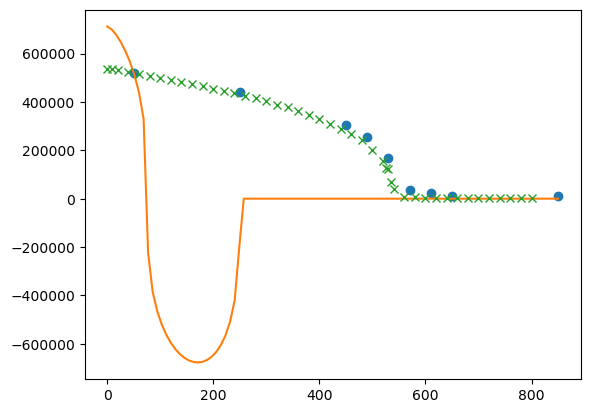

In [114]:
plt.plot(T_combined.value, Ms_combined.value, 'o')
plt.plot(T_fine, my_kuzmin(T_fine, *p_opt))
plt.plot(db_values.T.value, db_values.Ms.value, 'x')

We could use results from the Kuzmin fit as inputs for a micromagnetic simulation, e.g. to access parameters at 300 Kelvin (for which we did not run a simulation) we can use:

In [98]:
kuzmin_result.Ms(300)

Entity(ontology_label='SpontaneousMagnetization', value=np.float64(385450.7568460848), unit='A / m')

In [99]:
kuzmin_result.A(300)

Entity(ontology_label='ExchangeStiffnessConstant', value=np.float64(3.974129878658988e-12), unit='J / m')

## Estimating Tc

We can use the simulation results also to estimate Tc using different methods:
- Tc fit parameter returned from Kuzmin
- Peak in the specific heat at Tc
- Crossing of Binder cumulants at Tc when running simulations for different system sizes.

In the following, we will compare all three methods. First we run simulations for a second system size. We define a list of temperatures with uneven spacing which we then pass to the `temperature_sweep` method.

In [35]:
simulation.temperature_sweep(
    T=sorted(T_combined.value), out=material, ncell=[16, 16, 16], description="larger system size for U Binder",
    verbosity=2,
)

Running simulations for 9 different temperatures:
    [50.0, 250.0, 450.0, 490.0, 530.0, 570.0, 610.0, 650.0, 850.0]
T=50.0: Running UppASD in Fe2.33Ta0.67Y/2-temperature_sweep/0-run ... simulation finished, took 0:00:17
T=250.0: Running UppASD in Fe2.33Ta0.67Y/2-temperature_sweep/1-run ... simulation finished, took 0:00:17
T=450.0: Running UppASD in Fe2.33Ta0.67Y/2-temperature_sweep/2-run ... simulation finished, took 0:00:19
T=490.0: Running UppASD in Fe2.33Ta0.67Y/2-temperature_sweep/3-run ... simulation finished, took 0:00:18
T=530.0: Running UppASD in Fe2.33Ta0.67Y/2-temperature_sweep/4-run ... simulation finished, took 0:00:17
T=570.0: Running UppASD in Fe2.33Ta0.67Y/2-temperature_sweep/5-run ... simulation finished, took 0:00:16
T=610.0: Running UppASD in Fe2.33Ta0.67Y/2-temperature_sweep/6-run ... simulation finished, took 0:00:16
T=650.0: Running UppASD in Fe2.33Ta0.67Y/2-temperature_sweep/7-run ... simulation finished, took 0:00:17
T=850.0: Running UppASD in Fe2.33Ta0.67Y/2-t

TemperatureSweepData('Fe2.33Ta0.67Y/2-temperature_sweep')

In [36]:
data.info()

,name,description,time_elapsed,T,initmag,restartfile,comment,ncell
0,0-temperature_sweep,,None,"[50, 250, 450, 650, 850]",NaN,NaN,NaN,NaN
1,1-temperature_sweep,,None,"[490, 530, 570, 610]",4.0,Fe2.33Ta0.67Y/0-temperature_sweep/2-run/restar...,NaN,NaN
2,2-temperature_sweep,,None,"[50.0, 250.0, 450.0, 490.0, 530.0, 570.0, 610....",NaN,NaN,larger system size for U Binder,"[16, 16, 16]"


In [37]:
different_size = data[2]
different_size.info()

,name,description,time_elapsed,T,comment,ncell,initmag,restartfile
0,0-run,,0:00:17,50.0,larger system size for U Binder,"[16, 16, 16]",NaN,NaN
1,1-run,,0:00:17,250.0,larger system size for U Binder,"[16, 16, 16]",4.0,Fe2.33Ta0.67Y/2-temperature_sweep/0-run/restar...
2,2-run,,0:00:19,450.0,larger system size for U Binder,"[16, 16, 16]",4.0,Fe2.33Ta0.67Y/2-temperature_sweep/1-run/restar...
3,3-run,,0:00:18,490.0,larger system size for U Binder,"[16, 16, 16]",4.0,Fe2.33Ta0.67Y/2-temperature_sweep/2-run/restar...
4,4-run,,0:00:17,530.0,larger system size for U Binder,"[16, 16, 16]",4.0,Fe2.33Ta0.67Y/2-temperature_sweep/3-run/restar...
5,5-run,,0:00:16,570.0,larger system size for U Binder,"[16, 16, 16]",4.0,Fe2.33Ta0.67Y/2-temperature_sweep/4-run/restar...
6,6-run,,0:00:16,610.0,larger system size for U Binder,"[16, 16, 16]",4.0,Fe2.33Ta0.67Y/2-temperature_sweep/5-run/restar...
7,7-run,,0:00:17,650.0,larger system size for U Binder,"[16, 16, 16]",4.0,Fe2.33Ta0.67Y/2-temperature_sweep/6-run/restar...
8,8-run,,0:00:16,850.0,larger system size for U Binder,"[16, 16, 16]",4.0,Fe2.33Ta0.67Y/2-temperature_sweep/7-run/restar...


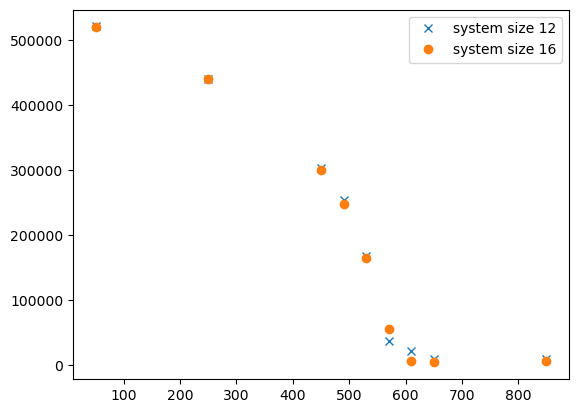

In [120]:
plt.plot(T_combined.value, Ms_combined.value, 'x', label="system size 12")
plt.plot(different_size.T.value, different_size.Ms.value, 'o', label="system size 16")
plt.legend()

In [39]:
mammos_analysis.kuzmin.kuzmin_properties(T=different_size.T, Ms=different_size.Ms).Tc

Entity(ontology_label='CurieTemperature', value=np.float64(376.4721208163407), unit='K')

In [40]:
p_opt[1]

np.float64(548.1542819623327)

In [121]:
my_kuzmin_fit(different_size.T, different_size.Ms);

Ms(T=0): 711917.2359094982
Tc: 249.999850117906
s: 8.243247105506029


/tmp/ipykernel_86161/1580605271.py:2: OptimizeWarning: Covariance of the parameters could not be estimated
  p_opt, p_cov = scipy.optimize.curve_fit(


For comparison we can also check Tc computed via Kuzmin using the data from the database. We can see that due to the limited accuracy of the simulations in this notebook we are off by a few (ten) Kelvin).

In [42]:
U_binder_combined = np.concat(
    (coarse_sweep.U_binder[:6], fine_sweep.U_binder, coarse_sweep.U_binder[6:])
)
U_binder_combined

array([0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667,
       0.66666667, 0.66666667, 0.66666667, 0.66666667])

---

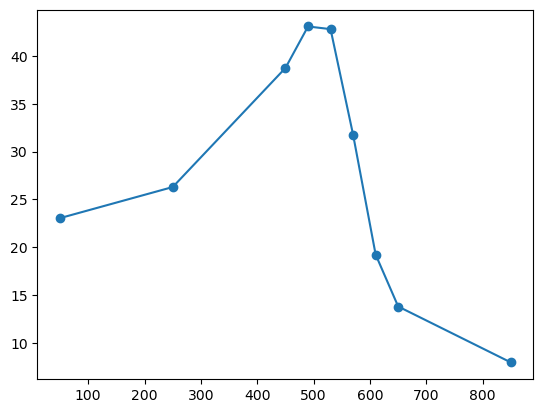

In [43]:
plt.plot(different_size.T.value, different_size.Cv.value, 'o-')

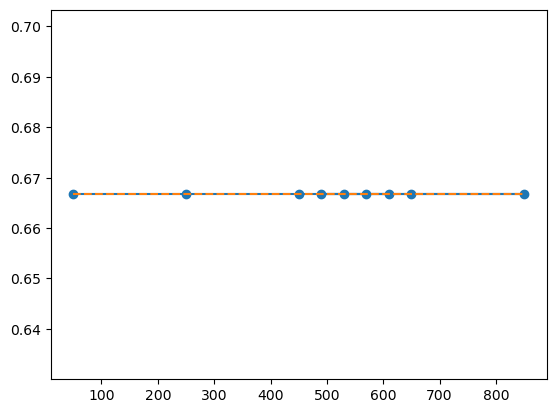

In [44]:
plt.plot(T_combined.value, U_binder_combined, 'o-')
plt.plot(different_size.T.value, different_size.U_binder, '--')

In [45]:
import pandas as pd

In [46]:
thermal = pd.read_csv(different_size.out / 'M(T)', sep=r"\s+")
thermal

,T,#Iter,<M>,<M^2>,<M^4>,U_{Binder},\chi,C_v(tot),<E>,<E_{exc}>,<E_{lsf}>
0,50,1,1.584609,2.510985,6.305045e+00,0.666667,0.0,0.0,-6.645944,-6.645944,0.0
1,250,1,1.339575,1.794462,3.220093e+00,0.666667,0.0,0.0,-5.255631,-5.255631,0.0
2,450,1,0.914565,0.836429,6.996128e-01,0.666667,0.0,0.0,-3.473553,-3.473553,0.0
3,490,1,0.753610,0.567929,3.225430e-01,0.666667,0.0,0.0,-2.984009,-2.984009,0.0
4,530,1,0.504000,0.254016,6.452393e-02,0.666667,0.0,0.0,-2.434298,-2.434298,0.0
5,570,1,0.170571,0.029095,8.464961e-04,0.666667,0.0,0.0,-1.951428,-1.951428,0.0
6,610,1,0.022621,0.000512,2.618388e-07,0.666667,0.0,0.0,-1.668098,-1.668098,0.0
7,650,1,0.013912,0.000194,3.746320e-08,0.666667,0.0,0.0,-1.487354,-1.487354,0.0
8,850,1,0.019058,0.000363,1.319284e-07,0.666667,0.0,0.0,-1.006929,-1.006929,0.0


In [47]:
U_binder = np.array(1 - thermal['<M^4>'] / (3 * thermal['<M^2>']))
U_binder

array([0.16300503, 0.40184609, 0.72119047, 0.81069044, 0.91532813,
       0.9903018 , 0.99982943, 0.99993548, 0.99987893])

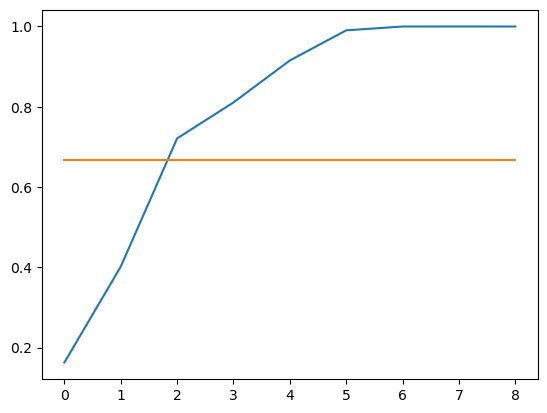

In [48]:
plt.plot(U_binder)
plt.plot(thermal["U_{Binder}"])

In [49]:
thermal_coarse = pd.read_csv(coarse_sweep.out / 'M(T)', sep=r"\s+")
thermal_fine = pd.read_csv(fine_sweep.out / 'M(T)', sep=r"\s+")

In [50]:
comb = pd.concat((thermal_coarse, thermal_fine)).sort_values(by="T")

In [51]:
U_binder_s = np.array(1 - comb['<M^4>'] / (3 * comb['<M^2>']))
U_binder_s

array([0.16289289, 0.40221082, 0.717152  , 0.80104626, 0.91260808,
       0.99573532, 0.99838332, 0.99971106, 0.9997335 ])

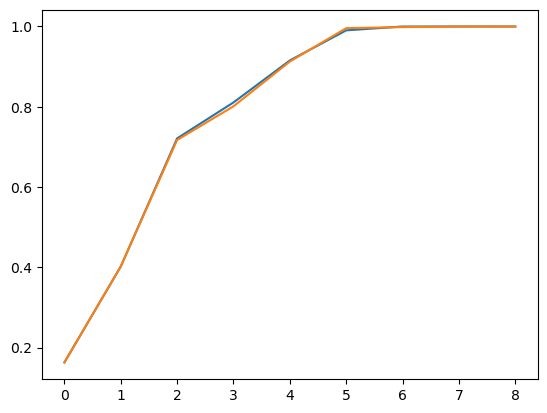

In [55]:
plt.plot(U_binder)
plt.plot(U_binder_s)

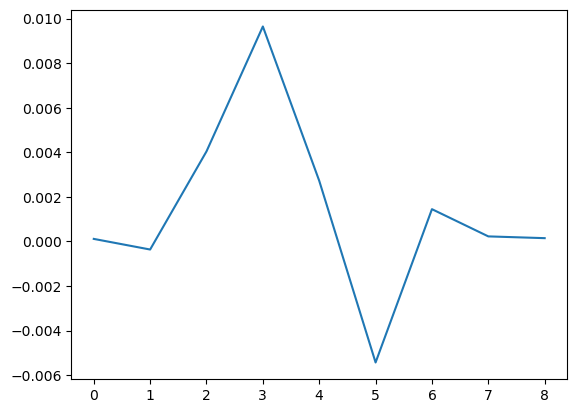

In [56]:
plt.plot(U_binder - U_binder_s)

In [57]:
import scipy.optimize

In [58]:
import scipy.interpolate

In [59]:
T = different_size.T.value
T

array([ 50., 250., 450., 490., 530., 570., 610., 650., 850.])

In [60]:
U_binder_int = scipy.interpolate.interp1d(T, U_binder, kind='cubic')

In [61]:
U_binder_s_int = scipy.interpolate.interp1d(T, U_binder_s, kind='cubic')

In [62]:
T_fine = np.linspace(400, 600, 100)

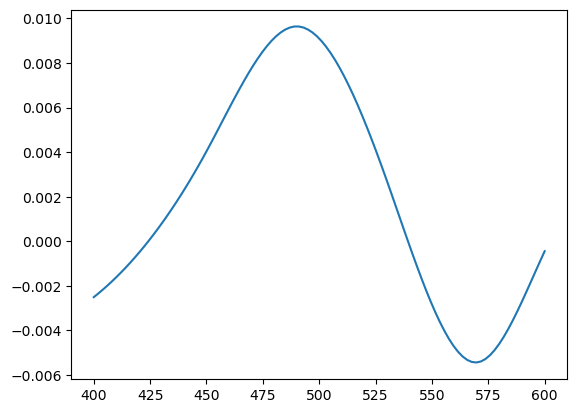

In [63]:
plt.plot(T_fine, U_binder_int(T_fine) - U_binder_s_int(T_fine))

In [64]:
p_opt_db

array([5.26244896e+05, 5.36728750e+02, 1.70365770e+00])

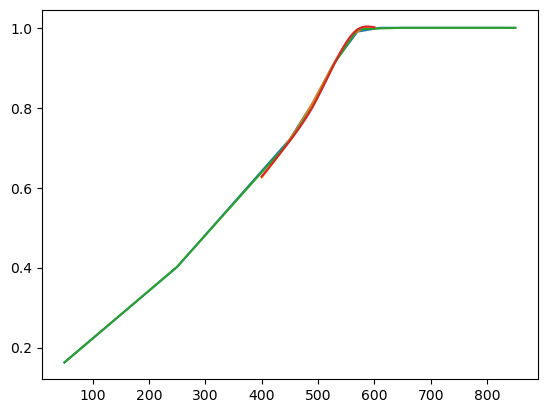

In [67]:
plt.plot(T, U_binder)
plt.plot(T_fine, U_binder_int(T_fine))

plt.plot(T, U_binder_s)
plt.plot(T_fine, U_binder_s_int(T_fine))

In [69]:
scipy.optimize.brentq(lambda x: U_binder_int(x) - U_binder_s_int(x), 450, 550)

539.3778194170017

In [122]:
p_opt_db[1]

np.float64(536.7287491955258)

In [70]:
p_opt[1]

np.float64(548.1542819623327)

In [71]:
different_size.T.q[different_size.Cv.value.argmax()]

<Quantity 490. K>

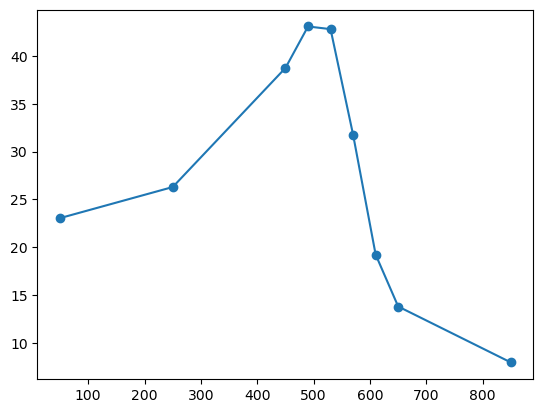

In [72]:
plt.plot(different_size.T.value, different_size.Cv.value, 'o-')

In [78]:
def lorentz(T, Tc, gamma, a):
    return a / ((T**2 - Tc**2)**2 + gamma**2 * T**2)

In [79]:
l_opt , _ = scipy.optimize.curve_fit(
    lorentz, different_size.T.value, different_size.Cv.value,
    (600, 100, 1e8)
)
l_opt

array([5.24187460e+02, 3.73853887e+02, 1.45280641e+12])

In [80]:
T_fine = np.linspace(50, 800, 100)

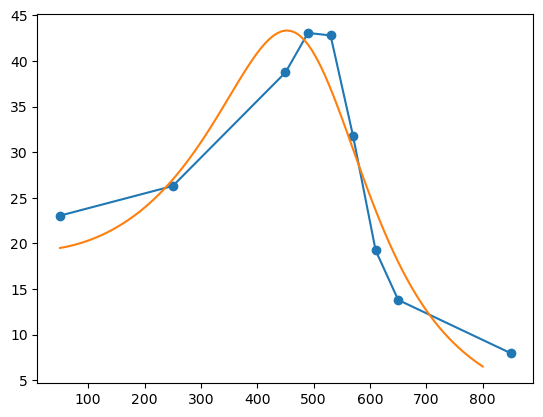

In [81]:
plt.plot(different_size.T.value, different_size.Cv.value, 'o-')
plt.plot(T_fine, lorentz(T_fine, *l_opt))

In [82]:
scipy.optimize.minimize(lambda x: lorentz(-x, *l_opt), 500)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.006056764757485421
        x: [ 3.961e+03]
      nit: 13
      jac: [-6.196e-06]
 hess_inv: [[ 3.967e+07]]
     nfev: 40
     njev: 20

In [83]:
p_opt_db[1]

np.float64(536.7287497626633)

In [84]:
l_opt[0]

np.float64(524.1874601192935)